# **Task 6: Template Fitting of Extragalactic Objects' Spectra:**
This example will walk you through the basic template fitting of a 1-dimension spectrum of Seyfert-1 galaxy. The spectrum, although (in some cases) dominated by the AGN, contain significant fraction of host galaxy flux and features.

Install the following require packages:

*   astropy
*   extinction
*   astroML
*   specutils



In [ ]:
!pip install astropy
!pip install astroML
!pip install spectres
!pip install specutils
# Installing needed Python packages

First, let's call in the usual suspects (i.e. import normally used packages)


*   NumPy
*   SciPy
*   Matplotlib.Pyplot
*   etc...

And also the packages you just installed (for online participants).



In [88]:
import numpy as np
from urllib.error import HTTPError
from astroML.datasets import fetch_sdss_spectrum

from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy import units as u
from astropy.nddata import NDData, StdDevUncertainty
from astropy.modeling.models import Linear1D, Polynomial1D
from spectres import spectres

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal

import specutils # again for the version number
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import correlation


#**Block 6.1:**
Now, let's read in a spectrum of Seyfert-1 galaxy and also a template of AGN from the folders.

(1.5537199974060059, 53.986571121215825)

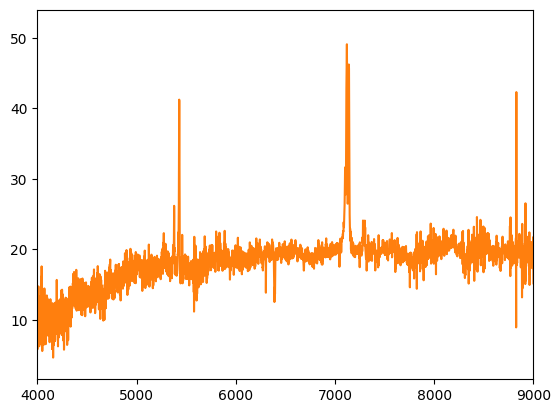

In [90]:
data_file_path = 'data/table_dr17_all_low_luminosity_AGN.csv' # check what is the correct path here
objID, ra, dec, plate, fiberID, redshift_table, mjd = np.loadtxt(data_file_path, usecols=(0,1,2,13,14,15,22), unpack=True, skiprows=1, delimiter=',')
plt.hist(redshift_table,bins=10)

def get_sdss_spec(plate,mjd,fiber): # in Place of 'Macro subtract_plot 13'
    try:
        spec = fetch_sdss_spectrum(plate, mjd, fiber)
    except HTTPError:
        print("%i, %i, %i not found" % (plate, mjd, fiber))
        spec = None
    return spec

index = 25

spec1 = get_sdss_spec(plate[index],mjd[index],fiberID[index])

wvl_1      = spec1.wavelength()
flux_1     = spec1.spectrum
flux_err_1 = spec1.error
z_listed_1 = spec1.z

plt.plot(wvl_1,flux_1)
plt.xlim([4000,9000])
plt.ylim([np.min(flux_1),1.1*np.max(flux_1)])


(0.00685, 0.0740003)

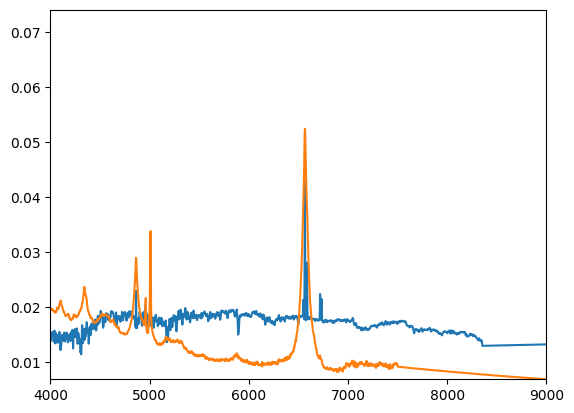

In [91]:
# Reading in Templates

template_agn_path = 'data/eigenspectra/agn/eigSpec_qso_'
template_gal_path = 'data/eigenspectra/galaxy/galaxyKL_eigSpec_'


gal_ord = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
agn_ord = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']

# Try the first order eigenspectrum of each catagory first
# Plot them to see what they look like
lambda_gal, f_gal0 = np.loadtxt(template_gal_path + gal_ord[0] + '.dat', unpack=True, usecols = (0,1))
lambda_agn, f_agn0 = np.loadtxt(template_agn_path + agn_ord[0] + '.dat', unpack=True, usecols = (0,1))

plt.plot(lambda_gal,f_gal0)
plt.plot(lambda_agn,f_agn0)
plt.xlim([4000,9000])
plt.ylim([np.min(f_agn0),1.1*np.max(f_agn0)])


#**Block 6.2:**
Since that you see what the templates look like.
Decide what would be the most appropriate to extract redshift of our "real" galaxy.


*   Perform cross-corelation
*   Before that, we need to "clean" the spectra (both observed and template) from continuum.
*   Why is that the case?
*   Does this change your prior decision/conclusion?



In [92]:
#Put the template and the observed spectrum into "Spectrum1D" packaging
#First crop the template to between 4000 to 8000 angstrom

tem_crop = np.where((lambda_gal >= 4000.0) & (lambda_gal <= 8000.0))
flux_unit = u.Unit('erg s^-1 cm^-2 AA^-1')
template = Spectrum1D(spectral_axis=(lambda_gal[tem_crop]*u.AA), flux=f_gal0[tem_crop]*flux_unit)


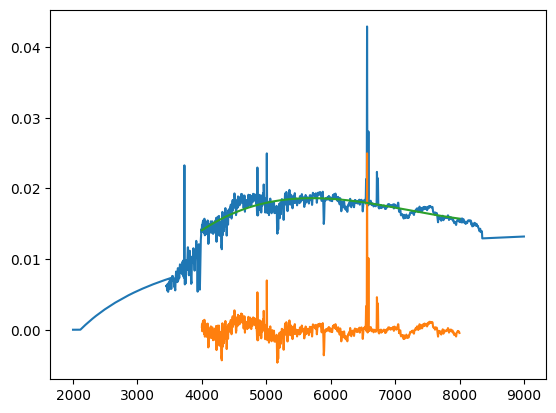

In [93]:
#Fit continuum using "fit_generic_continuum"
fit_temp = fit_generic_continuum(template, median_window=3, model=Polynomial1D(3))
cont_temp = fit_temp(template.spectral_axis)
template_sub = template - cont_temp

plt.plot(lambda_gal,f_gal0)
plt.plot(template_sub.spectral_axis, template_sub.flux)
plt.plot(template_sub.spectral_axis, cont_temp)

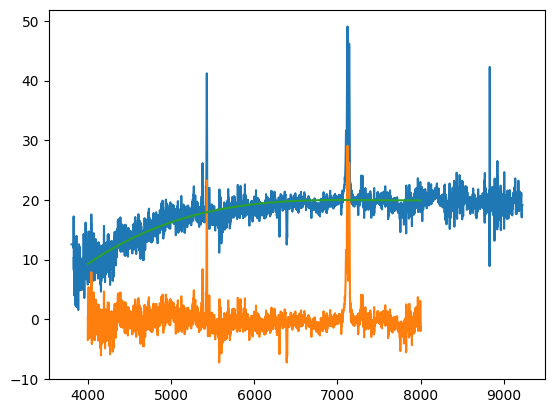

In [98]:
#Now fit and subtract of the continuum of the "observed" spectrum
obs_crop = np.where((wvl_1 >= 4000.0) & (wvl_1 <= 8000.0))

observed = Spectrum1D(spectral_axis=(wvl_1[obs_crop]*u.AA), flux=flux_1[obs_crop]*flux_unit, uncertainty=StdDevUncertainty(flux_err_1[obs_crop]))
fit_obseved   = fit_generic_continuum(observed, median_window=3, model=Polynomial1D(3))
cont_observed = fit_obseved(observed.spectral_axis)
observed_sub  = observed - cont_observed

plt.plot(wvl_1,flux_1)
plt.plot(observed_sub.spectral_axis, observed_sub.flux)
plt.plot(observed_sub.spectral_axis, cont_observed)


In [99]:
print(observed_sub)
print(template_sub)

Spectrum1D (length=3010)
flux:             [ -3.4693 erg / (Angstrom s cm2), ..., -1.348 erg / (Angstrom s cm2) ],  mean=0.0080572 erg / (Angstrom s cm2)
spectral axis:    [ 4000.4 Angstrom, ..., 7998.3 Angstrom ],  mean=5770.4 Angstrom
uncertainty:      [ StdDevUncertainty(1.6307768), ..., StdDevUncertainty(1.0215511) ]
Spectrum1D (length=3010)
flux:             [ 0.0004047 erg / (Angstrom s cm2), ..., -0.00046242 erg / (Angstrom s cm2) ],  mean=1.5302e-06 erg / (Angstrom s cm2)
spectral axis:    [ 4000.5 Angstrom, ..., 7998.7 Angstrom ],  mean=5770.7 Angstrom


#**Block 6.3: Good, good, goooood!**
Now, we are really ready for the cross-correlation part of the exercise.

*   Perform cross-corelation using "correlation.template_correlate(observed, template, lag_units=u...)" from "specutils.analysis"
*   Compare the redshift you get from this method to the listed redshift from SDSS.


/usr/local/lib/python3.10/dist-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


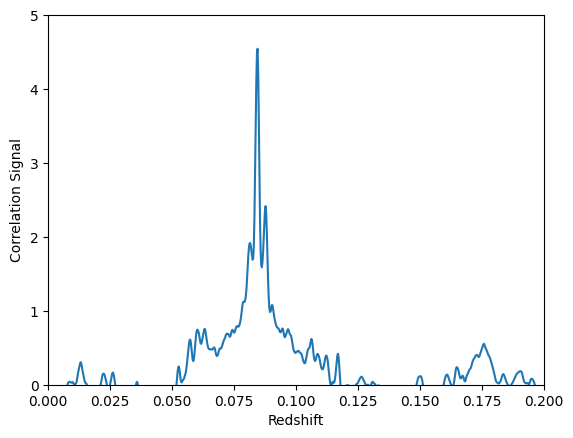

0.0841812 0.0844261957668695


In [108]:
# Call the correlation function
corr, lag = correlation.template_correlate(observed_sub, template_sub, lag_units=u.one)

# Plot the correlation
plt.plot(lag, corr)
plt.xlabel("Redshift")
plt.ylabel("Correlation Signal")
plt.xlim([0.0,0.2])
plt.ylim([0,5])
plt.show()

#Try ploting it first, then review where the peak(s) locates and zoom in!
z_peak = lag[np.where(corr==np.max(corr))][0]
print(z_listed_1, z_peak)

#**Block 6.4:**
**The Challenging Part**

If you feel incomplete after the series of fitting and fitting, let's do more "challenging" fitting.
As mentioned, the spectra here is one of the Seyfert-1 galaxies. So, the flux is blended between galaxies and those of active galactic nuclei.



*   Try a simple version of PCA decomposition of the spectrum.
*   Using the first 3 eigen spectra from each of AGN and galaxy types.
*   What is the contribution from each sources (host galaxy and AGN)




In [113]:
#Read in all necessary eigen spectra. No worries. For each type, they "might not" have the same wavelength array.
lambda_gal0, f_gal0 = np.loadtxt(template_gal_path + gal_ord[0] + '.dat', unpack=True, usecols = (0,1))
lambda_gal1, f_gal1 = np.loadtxt(template_gal_path + gal_ord[1] + '.dat', unpack=True, usecols = (0,1))
lambda_gal2, f_gal2 = np.loadtxt(template_gal_path + gal_ord[2] + '.dat', unpack=True, usecols = (0,1))

lambda_agn0, f_agn0 = np.loadtxt(template_agn_path + agn_ord[0] + '.dat', unpack=True, usecols = (0,1))
lambda_agn1, f_agn1 = np.loadtxt(template_agn_path + agn_ord[1] + '.dat', unpack=True, usecols = (0,1))
lambda_agn2, f_agn2 = np.loadtxt(template_agn_path + agn_ord[2] + '.dat', unpack=True, usecols = (0,1))

def eigen_model(x,a0,a1,a2,g0,g1,g2):
  fg0 = np.interp(x,lambda_gal0,f_gal0)
  fg1 = np.interp(x,lambda_gal1,f_gal1)
  fg2 = np.interp(x,lambda_gal2,f_gal2)

  fa0 = np.interp(x,lambda_agn0,f_agn0)
  fa1 = np.interp(x,lambda_agn1,f_agn1)
  fa2 = np.interp(x,lambda_agn2,f_agn2)

  flux_dens_total = a0*fa0 + a1*fa1 + a2*fa2 + g0*fg0 + g1*fg1 + g2*fg2
  return flux_dens_total

#print(len(f_agn1),len(f_agn2),len(f_agn0), len(lambda_agn))


2869 1879 2672 2672


De-redshift the observed spectrum into rest wavelegth and fit it with the function you just built!


In [ ]:
wvl_1_rest = wvl_1/(1.0 + z_peak)
eigen_vals, eigen_covs = curve_fit(eigen_model, wvl_1_rest, flux_1)
print(eigen_vals)

# show your work/result in the plot...
plt.plot(wvl_1_rest, flux_1, 'c-')
plt.plot(wvl_1_rest, eigen_model(wvl_1_rest, eigen_vals[0], eigen_vals[1], eigen_vals[2],
                                  eigen_vals[3], eigen_vals[4], eigen_vals[5]), 'k--')
plt.plot(wvl_1_rest, eigen_model(wvl_1_rest, eigen_vals[0], eigen_vals[1], eigen_vals[2],
                                  0, 0, 0), 'b-')
plt.plot(wvl_1_rest, eigen_model(wvl_1_rest, 0,0,0,
                                  eigen_vals[3], eigen_vals[4], eigen_vals[5]), 'r-')


gal_part = eigen_model(wvl_1_rest, 0,0,0,eigen_vals[3], eigen_vals[4], eigen_vals[5])
agn_part = eigen_model(wvl_1_rest, eigen_vals[0], eigen_vals[1], eigen_vals[2],0, 0, 0)

#Estimate the "host fraction" at wavelenth < 4000.0 angstrom and again at > 7000.0 angstrom
host_frac_blue = np.average(gal_part[np.where(wvl_1_rest < 4000.0)]/
 (gal_part[np.where(wvl_1_rest < 4000.0)] + agn_part[np.where(wvl_1_rest < 4000.0)]))
host_frac_red = np.average(gal_part[np.where(wvl_1_rest > 7000.0)]/
 (gal_part[np.where(wvl_1_rest > 7000.0)] + agn_part[np.where(wvl_1_rest > 7000.0)]))

print(host_frac_blue, host_frac_red)

**Is this finding in line with the stuff you (may) have learn about AGN?**